### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2024-07-09 17:20:25.200156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 17:20:25.200220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 17:20:25.201758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Resize and Rescale Image

In [2]:
def resize_and_scale(image_path, label_path, new_shape=(448, 448)):
    
    file = tf.io.read_file(image_path)
    img = tf.image.decode_image(file, channels=3)

    img = tf.image.resize(img, new_shape)

    # Normalize the pixel values of the image to [0, 1]
    img = img / 255.0

    scale_factor_x = new_shape[0] / img.shape[0]
    scale_factor_y = new_shape[1] / img.shape[1]

    with open(label_path, 'r') as handle:
        labels = handle.readlines()
        
        all_labels = []
        
        for label in labels:
            label = label.replace('\n', '').split()
            label[0] = int(label[0])
            label[1] = float(label[1]) * scale_factor_x
            label[2] = float(label[2]) * scale_factor_y
            label[3] = float(label[3]) * scale_factor_x
            label[4] = float(label[4]) * scale_factor_y
            
            all_labels.append(label)
            
    return [img, all_labels]

### Ploting Image and Bounding Boxes

In [3]:
def plot_bounding_boxes(image_tensor, boxes):
    # Converting the image tensor to a NumPy array if needed
    if isinstance(image_tensor, tf.Tensor):
        image_tensor = image_tensor.numpy()

    # Converting grayscale image to RGB if needed (to display the box in red)
    if len(image_tensor.shape) == 2:
        image_tensor = np.stack((image_tensor,) * 3, axis=-1)

    # Creating a copy of the image to draw the bounding boxes
    image_with_boxes = np.copy(image_tensor)

    # Drawing the bounding box on the image using PIL for each box
    box_color = (255, 0, 0)  
    thickness = 2  
    image_pil = Image.fromarray(np.uint8(image_with_boxes))
    draw = ImageDraw.Draw(image_pil)

    for box in boxes:
        cx, cy, w, h = box

        # Converting the normalized bounding box to absolute pixel values
        image_height, image_width = image_tensor.shape[:2]
        box_x = int(cx * image_width)
        box_y = int(cy * image_height)
        box_width = int(w * image_width)
        box_height = int(h * image_height)

        # Calculating the top-left and bottom-right coordinates of the bounding box
        top_left = (box_x - box_width // 2, box_y - box_height // 2)
        bottom_right = (box_x + box_width // 2, box_y + box_height // 2)

        # Drawing the bounding box on the image
        draw.rectangle([top_left, bottom_right], outline=box_color, width=thickness)

    # Converting back to NumPy array and display the image with the bounding boxes
    image_with_boxes = np.array(image_pil)
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()


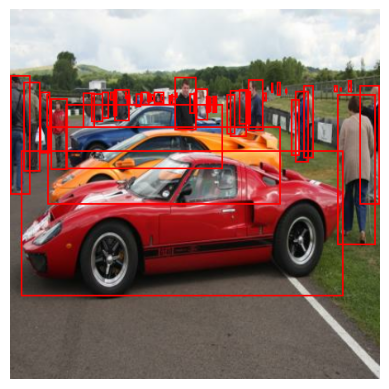

In [4]:
# Lets visualize one example
main_path = "/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/train/"
img_path = os.path.join(main_path, 'images/image_000000128_jpg.rf.3c2619a2c608f7e2b4d769a8c968e9b3.jpg')
label_path = os.path.join(main_path, 'labels/image_000000128_jpg.rf.3c2619a2c608f7e2b4d769a8c968e9b3.txt')

image, labels = resize_and_scale(img_path, label_path, new_shape=(448, 448))

boxes = [x[1:5] for x in labels]

plot_bounding_boxes(image * 255.0, boxes)

### Selecting Anchor Boxes

In [5]:
def kmeans_anchors(file_dir_path, num_anchors, num_iterations=1000):
    
    files = os.listdir(file_dir_path)

    # Extracting bounding box coordinates from each file's label and store in 'boxes' list
    boxes = []
    for file in files:
        with open(os.path.join(file_dir_path, file), 'r') as handle:
            labels = handle.readlines()
           
        for label in labels:
            label = label.strip().split()
            box = label[3:] 
            boxes.append(box)
            
    # Using KMeans clustering to find 'num_anchors' anchor boxes
    kmeans = KMeans(n_clusters=num_anchors, max_iter=num_iterations)
    kmeans.fit(boxes)
    anchor_boxes = kmeans.cluster_centers_

    return anchor_boxes


### Encoding the ground Truth Labels

In [7]:
def ground_label(input_size, labels, anchor_boxes, n_classes):
    n_anchor = len(anchor_boxes)
    grid_shape = input_size[0] // 64, input_size[1] // 64 # This will result to 7 x 7 grid since the image is with 448
    
    ground_labels = np.zeros((grid_shape[0], grid_shape[1], n_anchor, 5 + n_classes))
    
    for label in labels:
        idx, cx, cy, w, h = label

        # Calculating the grid cell coordinates (x and y) where the bounding box belongs
        grid_x = int(cx * (grid_shape[1]))
        grid_y = int(cy * (grid_shape[0]))
        
        # Calculate the width and height of the bounding box relative to the entire image (YOLO requirement)
        width_rel_to_img = w * input_size[1] / grid_shape[1]
        height_rel_to_img = h * input_size[0] / grid_shape[0]
        
        # Finding the best matching anchor box for the object based on Intersection over Union (IoU)
        best_anchor_idx = -10
        best_iou = -10
        
        for a_idx, anchor in enumerate(anchor_boxes):
            a_width, a_height = anchor
            intersection_width = min(cx + w / 2, cx + a_width / 2) - max(cx - w / 2, cx - a_width / 2)
            intersection_height = min(cy + h / 2, cy + a_height / 2) - max(cx - h / 2, cx - a_height / 2)
            intersection = intersection_width * intersection_height
            union = (w * h) + (a_width * a_height) - intersection
            iou = intersection / union
            
            if iou > best_iou:
                best_iou = iou
                best_anchor_idx = a_idx
                
        # Encoding the ground truth bounding box in the grid cell
        ground_labels[grid_y, grid_x, best_anchor_idx, 0] = 1.0  
        ground_labels[grid_y, grid_x, best_anchor_idx, 1] = cx * grid_shape[1] - grid_x
        ground_labels[grid_y, grid_x, best_anchor_idx, 2] = cy * grid_shape[0] - grid_y
        ground_labels[grid_y, grid_x, best_anchor_idx, 3] = width_rel_to_img
        ground_labels[grid_y, grid_x, best_anchor_idx, 4] = height_rel_to_img
        ground_labels[grid_y, grid_x, best_anchor_idx, 5 + idx] = 1.0

    return ground_labels.reshape((grid_shape[0], grid_shape[1], n_anchor * (5 + n_classes)))

### The preprocessing function

In [8]:
def preprocess(image_path, label_path, new_shape, anchor, n_classes):
    images = os.listdir(image_path)
    labels = os.listdir(label_path)
    X, y = [], []
    
    for image in images: 
        img_name, ext = os.path.splitext(image)
        txt_file_name = img_name + ".txt"

        image_full_path = os.path.join(image_path, image)
        label_full_path = os.path.join(label_path, txt_file_name)

        if os.path.isfile(label_full_path):
            image_tensor, labels = resize_and_scale(image_full_path, label_full_path, new_shape=(448, 448))
            ground_labels = ground_label((448, 448), labels, anchor, n_classes)
            
            X.append(image_tensor)
            y.append(ground_labels)
            
        else:
            pass
        
    return np.array(X), np.array(y)

### Putting them all Together

In [9]:
train_image_path = '/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/train/images'
train_label_path = '/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/train/labels'
val_image_path = '/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/valid/images'
val_label_path = '/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/valid/labels'
test_image_path = '/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/test/images'
test_label_path = '/kaggle/input/car-person-v2-roboflow/Car-Person-v2-Roboflow-Owais-Ahmad/test/labels'

anchor_boxes = kmeans_anchors(train_label_path, 3, num_iterations=1000)

train_dataset = preprocess(train_image_path, train_label_path, (448,448), anchor_boxes, 2)
val_dataset = preprocess(val_image_path, val_label_path, (448,448), anchor_boxes, 2)
test_dataset = preprocess(test_image_path, test_label_path, (448,448), anchor_boxes, 2)

In [10]:
print('shape of X_train', train_dataset[0].shape)
print('Shape of y_train', train_dataset[1].shape)
print('shape of X_validation', val_dataset[0].shape)
print('shape of y_validation', val_dataset[1].shape)
print('shape of X_test', test_dataset[0].shape)
print('shape of y_test', test_dataset[1].shape)

shape of X_train (1571, 448, 448, 3)
Shape of y_train (1571, 7, 7, 21)
shape of X_validation (448, 448, 448, 3)
shape of y_validation (448, 7, 7, 21)
shape of X_test (224, 448, 448, 3)
shape of y_test (224, 7, 7, 21)


### Model Architecture

In [11]:
def create_model(input_shape, num_anchors, num_classes):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    # First Conv block
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Second Conv block
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Third Conv block
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Fourth Conv block
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Fifth Conv block
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Sixth Conv block
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Seventh Conv block
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
    
    # Output layer
    output = tf.keras.layers.Conv2D(num_anchors * (5 + num_classes), (1, 1), padding='same', activation='linear')(x)
    
    output = tf.keras.layers.Reshape((7, 7, num_anchors * (5 + num_classes)))(output)
    
    model = tf.keras.Model(input_layer, output)
    
    return model

### Model hyperparameters

In [12]:
input_shape = (448, 448, 3)
num_anchors = len(anchor_boxes)
num_classes = 2

### Creating the model

In [13]:
model = create_model(input_shape, num_anchors, num_classes)

### Defining loss function

In [14]:
def yolo_loss(y_true, y_pred):
    obj_mask = y_true[..., 0]
    noobj_mask = 1 - obj_mask

    xy_loss = obj_mask * tf.reduce_sum(tf.square(y_true[..., 1:3] - y_pred[..., 1:3]), axis=-1)
    wh_loss = obj_mask * tf.reduce_sum(tf.square(tf.sqrt(y_true[..., 3:5]) - tf.sqrt(y_pred[..., 3:5])), axis=-1)
    conf_loss = obj_mask * tf.square(y_true[..., 0] - y_pred[..., 0]) + noobj_mask * tf.square(y_true[..., 0] - y_pred[..., 0])
    class_loss = obj_mask * tf.reduce_sum(tf.square(y_true[..., 5:] - y_pred[..., 5:]), axis=-1)

    loss = xy_loss + wh_loss + conf_loss + class_loss
    return tf.reduce_mean(loss)


### Model Compilation

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 448, 448, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 21)       │        21,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 21)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,747,925 (60.07 MB)

 Trainable params: 15,747,925 (60.07 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [17]:
epochs = 50
batch_size = 8

history = model.fit(train_dataset[0], train_dataset[1], 
    validation_data=(val_dataset[0], val_dataset[1]), 
    epochs=epochs, batch_size=batch_size)

Epoch 1/50
  1/197 ━━━━━━━━━━━━━━━━━━━━ 1:16:59 24s/step - accuracy: 0.1403 - loss: 4.6622

I0000 00:00:1720546573.510362     245 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - accuracy: 0.0388 - loss: 4.5163 - val_accuracy: 0.0420 - val_loss: 4.1528
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0438 - loss: 4.0957 - val_accuracy: 0.0478 - val_loss: 4.0914
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.0504 - loss: 4.2002 - val_accuracy: 0.0466 - val_loss: 4.1233
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.0471 - loss: 4.2962 - val_accuracy: 0.0492 - val_loss: 4.0634
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0504 - loss: 4.0893 - val_accuracy: 0.0494 - val_loss: 4.0354
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0489 - loss: 4.1309 - val_accuracy: 0.0473 - val_loss: 4.0080
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0478 - loss: 3.9191 - val_accuracy: 0.0502 - val_loss: 4.0080
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.0484 - loss: 3.8225 - val_accura

### Model Evaluation

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset[0], test_dataset[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.0325 - loss: 4.3026


### Plotting Accuracy and loss

In [19]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy*100}')

Test Loss: 4.270060062408447
Test Accuracy: 3.3072154968976974


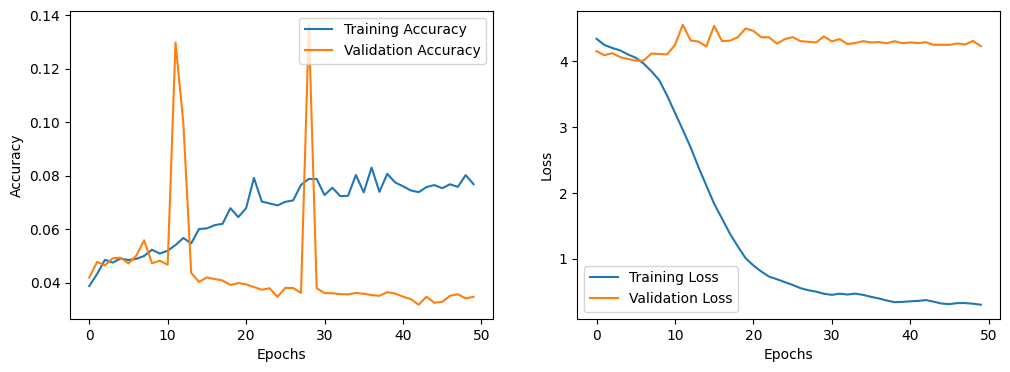

In [20]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
model_json = model.to_json()
with open("car_person_model_json.json","w") as json_file:
    json_file.write(model_json)

In [22]:
model.save("CarPersonModel.h5")